# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

For the first part of the project we will tackle the frozen lake Envirement which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Envirement description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [130]:
import gymnasium as gym
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt
import pandas as pd

We will experiment with both conditions `is_slippery=True` and `is_slippery=False`

In [191]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

# 1. Algorithms
### 1.1 Q-Learning

In [192]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.01, gamma=0.9, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done or truncated: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [193]:
q_table = q_train(env)

# q_table = q_train(env, weights="data/q_table.npy")
# np.save('data/q_table.npy', q_table)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2057.30it/s]

Finished Q-learning algorithm.
Average reward is : 0.0


### 1.2 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [194]:
def q_train_greedy(env, alpha=0.99, gamma=0.9, epsilon=0.1, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [198]:
q_table_greedy = q_train_greedy(env)
# q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
# np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1781.93it/s]

Finished Q-learning algorithm.
Average reward is : 0.0830747672905615



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [199]:

def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [200]:
q_table_greedy_decay=q_train_greedy_decay(env)
# q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
# np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1119.42it/s]

Finished Q-learning algorithm.
Average reward is : 0.347928872443211


### 1.4 SARSA

In [201]:
def sarsa_train(env, alpha=0.1, gamma=1, epsilon=0.5, episodes=10000, steps=1000) :

    num_actions = env.action_space.n
    num_states = env.observation_space.n
    q = np.zeros((num_states, num_actions))

    for ep in trange(episodes) : 
        
        env.reset()
        state = env.s

        
        if np.random.uniform() < epsilon :
            action = env.action_space.sample()
        else :
            action = np.argmax(q[state, :])
            
        for _ in range(steps) :
            nw_state, reward, terminated, truncated, info = env.step(action)
            
            if np.random.uniform() < epsilon :
                nw_action = env.action_space.sample()
            else :
                nw_action = np.argmax(q[nw_state, :])
                
            q[state, action] = (1-alpha)*q[state, action] + \
                alpha*(reward + gamma*q[nw_state, nw_action])
                
            state = nw_state
            action = nw_action
            
            if terminated or truncated :
                break
    
    env.close()
    
    return q

In [202]:
sarsa_table = sarsa_train(env, alpha = 0.1, gamma = 1, epsilon = 0.5, episodes = 10000, steps = 1000)

100%|██████████| 10000/10000 [00:03<00:00, 2922.94it/s]


In [203]:
def agent_play(env,q_table, max_n_episodes=10000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, tr,_ = env.step(a)
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps to succeed is = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [204]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table)


100%|██████████| 10000/10000 [00:00<00:00, 10182.00it/s]


Success rate is = 4.44 %
Average number of steps to succeed is = 5.0499


100%|██████████| 10000/10000 [00:02<00:00, 3468.15it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.0148


100%|██████████| 10000/10000 [00:06<00:00, 1452.84it/s]


Success rate is = 55.52 %
Average number of steps to succeed is = 43.3423


100%|██████████| 10000/10000 [00:06<00:00, 1487.17it/s]


Success rate is = 72.72999999999999 %
Average number of steps to succeed is = 41.3862


100%|██████████| 10000/10000 [00:06<00:00, 1636.27it/s]

Success rate is = 67.16 %
Average number of steps to succeed is = 37.855


## 2. comparaison

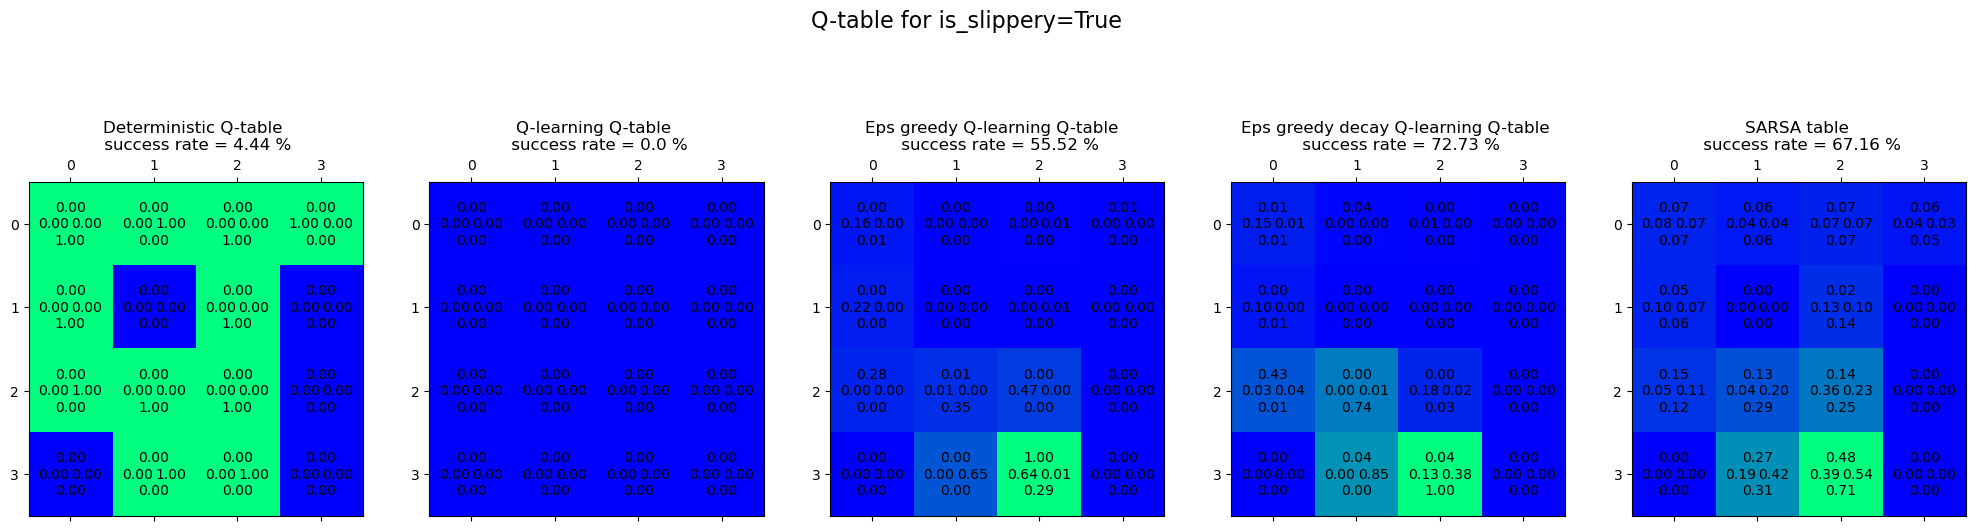

In [207]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
fig.suptitle("Q-table for is_slippery=True", fontsize=16)

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {round(100*success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {round(100*success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {round(100*success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {round(100*success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {round(100*success_rate_sarsa,2)} %")
plt.show()

Then we'll define a play function for our game to test the performance

/tmp/ipykernel_57852/995146866.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_57852/995146866.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_57852/995146866.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_57852/995146866.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-

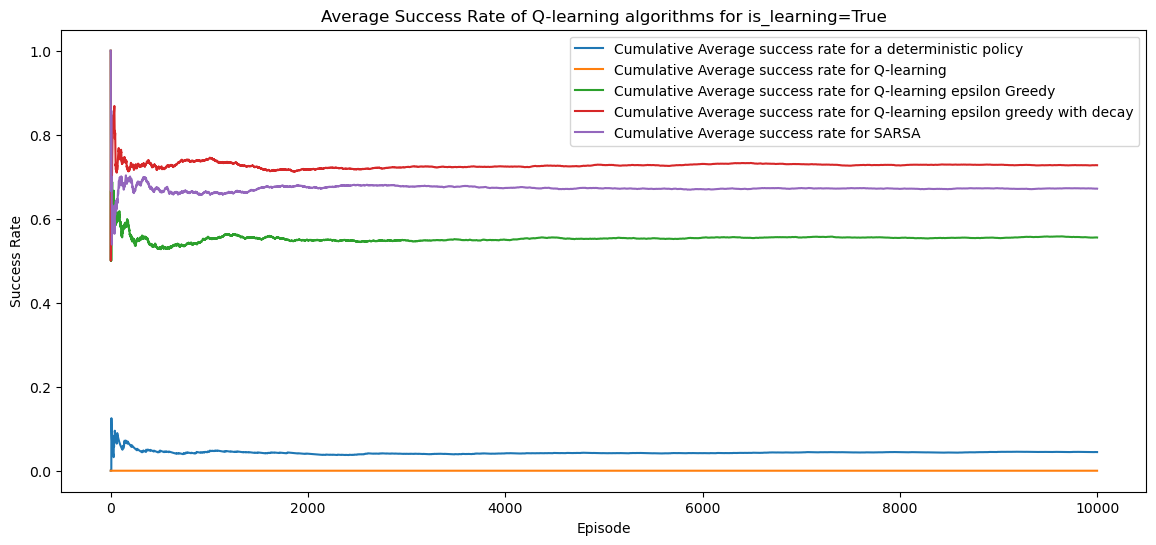

In [208]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=True')
plt.legend()
plt.show()

## 3. Hyperparameter tuning

In [140]:
# Qlearning optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards =[]
for al in alpha :
    for ga in gamma :
        for ep in epsilon :
            q_table = q_train_greedy_decay(env, alpha=al, gamma=ga, min_epsilon=ep)
            reward, success_rate, avg_nb_steps = agent_play(env, q_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(ep)
            rewards.append(reward)


Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 4014.70it/s]


Finished Q-learning algorithm.
Average reward is : 0.0477


100%|██████████| 10000/10000 [00:01<00:00, 8769.38it/s]


Success rate is = 5.37 %
Average number of steps to succeed is = 6.7356
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 3877.44it/s]


Finished Q-learning algorithm.
Average reward is : 0.0525


100%|██████████| 10000/10000 [00:01<00:00, 9379.04it/s]


Success rate is = 5.58 %
Average number of steps to succeed is = 5.9038
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2241.12it/s]


Finished Q-learning algorithm.
Average reward is : 0.06832733093237295


100%|██████████| 10000/10000 [00:02<00:00, 4466.94it/s]


Success rate is = 8.14081408140814 %
Average number of steps to succeed is = 14.009100910091009
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 3374.52it/s]


Finished Q-learning algorithm.
Average reward is : 0.0285


100%|██████████| 10000/10000 [00:02<00:00, 3524.33it/s]


Success rate is = 13.452690538107623 %
Average number of steps to succeed is = 17.43118623724745
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3248.93it/s]


Finished Q-learning algorithm.
Average reward is : 0.0751


100%|██████████| 10000/10000 [00:01<00:00, 6420.68it/s]


Success rate is = 8.9 %
Average number of steps to succeed is = 8.8863
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 4365.49it/s]


Finished Q-learning algorithm.
Average reward is : 0.0317


100%|██████████| 10000/10000 [00:01<00:00, 9711.78it/s]


Success rate is = 3.66 %
Average number of steps to succeed is = 5.9195
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3296.76it/s]


Finished Q-learning algorithm.
Average reward is : 0.0788


100%|██████████| 10000/10000 [00:01<00:00, 5233.27it/s]


Success rate is = 14.84 %
Average number of steps to succeed is = 11.3197
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2764.39it/s]


Finished Q-learning algorithm.
Average reward is : 0.0327


100%|██████████| 10000/10000 [00:09<00:00, 1092.46it/s]


Success rate is = 40.940012368583794 %
Average number of steps to succeed is = 30.58008658008658
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1575.90it/s]


Finished Q-learning algorithm.
Average reward is : 0.0531


100%|██████████| 10000/10000 [00:01<00:00, 5427.32it/s]


Success rate is = 6.140000000000001 %
Average number of steps to succeed is = 6.9186
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2327.97it/s]


Finished Q-learning algorithm.
Average reward is : 0.0492


100%|██████████| 10000/10000 [00:01<00:00, 5415.16it/s]


Success rate is = 6.21 %
Average number of steps to succeed is = 7.3137
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3016.49it/s]


Finished Q-learning algorithm.
Average reward is : 0.0267


100%|██████████| 10000/10000 [00:01<00:00, 5363.64it/s]


Success rate is = 3.9800000000000004 %
Average number of steps to succeed is = 7.4593
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1673.39it/s]


Finished Q-learning algorithm.
Average reward is : 0.0406


100%|██████████| 10000/10000 [00:09<00:00, 1084.10it/s]


Success rate is = 75.6545608108108 %
Average number of steps to succeed is = 36.625316722972975
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 3652.40it/s]


Finished Q-learning algorithm.
Average reward is : 0.0297


100%|██████████| 10000/10000 [00:01<00:00, 5826.99it/s]


Success rate is = 3.32 %
Average number of steps to succeed is = 5.5833
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2729.64it/s]


Finished Q-learning algorithm.
Average reward is : 0.0296


100%|██████████| 10000/10000 [00:01<00:00, 6802.40it/s]


Success rate is = 2.94 %
Average number of steps to succeed is = 5.3488
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3003.23it/s]


Finished Q-learning algorithm.
Average reward is : 0.0646


100%|██████████| 10000/10000 [00:01<00:00, 5078.39it/s]


Success rate is = 12.29 %
Average number of steps to succeed is = 11.4417
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2051.08it/s]


Finished Q-learning algorithm.
Average reward is : 0.037


100%|██████████| 10000/10000 [00:06<00:00, 1489.43it/s]


Success rate is = 44.696811835799124 %
Average number of steps to succeed is = 33.91112731819129
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3283.62it/s]


Finished Q-learning algorithm.
Average reward is : 0.0426


100%|██████████| 10000/10000 [00:01<00:00, 6830.91it/s]


Success rate is = 4.8 %
Average number of steps to succeed is = 7.0719
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3160.94it/s]


Finished Q-learning algorithm.
Average reward is : 0.0869


100%|██████████| 10000/10000 [00:02<00:00, 3681.74it/s]


Success rate is = 18.269134567283643 %
Average number of steps to succeed is = 15.828714357178589
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2644.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.0332


100%|██████████| 10000/10000 [00:02<00:00, 4233.11it/s]


Success rate is = 5.54 %
Average number of steps to succeed is = 14.4906
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2830.88it/s]


Finished Q-learning algorithm.
Average reward is : 0.037


100%|██████████| 10000/10000 [00:05<00:00, 1777.33it/s]


Success rate is = 44.44444444444444 %
Average number of steps to succeed is = 33.06460674157304
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 3952.08it/s]


Finished Q-learning algorithm.
Average reward is : 0.0518


100%|██████████| 10000/10000 [00:01<00:00, 8780.09it/s]


Success rate is = 5.63 %
Average number of steps to succeed is = 6.7505
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:02<00:00, 3914.40it/s]


Finished Q-learning algorithm.
Average reward is : 0.0725


100%|██████████| 10000/10000 [00:01<00:00, 5759.77it/s]


Success rate is = 12.659999999999998 %
Average number of steps to succeed is = 10.3163
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2083.77it/s]


Finished Q-learning algorithm.
Average reward is : 0.11683505051515454


100%|██████████| 10000/10000 [00:04<00:00, 2442.89it/s]


Success rate is = 29.18940772185163 %
Average number of steps to succeed is = 26.189812007277137
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2789.54it/s]


Finished Q-learning algorithm.
Average reward is : 0.037


100%|██████████| 10000/10000 [00:05<00:00, 1869.86it/s]


Success rate is = 33.7241309001937 %
Average number of steps to succeed is = 29.435824243042106
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2175.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.08640864086408641


100%|██████████| 10000/10000 [00:02<00:00, 4287.59it/s]


Success rate is = 5.800000000000001 %
Average number of steps to succeed is = 7.657
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2119.82it/s]


Finished Q-learning algorithm.
Average reward is : 0.0843


100%|██████████| 10000/10000 [00:01<00:00, 5506.24it/s]


Success rate is = 8.58 %
Average number of steps to succeed is = 7.6847
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2308.17it/s]


Finished Q-learning algorithm.
Average reward is : 0.0731


100%|██████████| 10000/10000 [00:01<00:00, 6129.67it/s]


Success rate is = 10.13 %
Average number of steps to succeed is = 6.7917
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2376.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.0338


100%|██████████| 10000/10000 [00:02<00:00, 4473.54it/s]


Success rate is = 9.54 %
Average number of steps to succeed is = 9.0489
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1081.42it/s]


Finished Q-learning algorithm.
Average reward is : 0.28982880161127894


100%|██████████| 10000/10000 [00:06<00:00, 1482.45it/s]


Success rate is = 52.11138310893513 %
Average number of steps to succeed is = 29.25581395348837
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1221.21it/s]


Finished Q-learning algorithm.
Average reward is : 0.2114652234916817


100%|██████████| 10000/10000 [00:05<00:00, 1727.70it/s]


Success rate is = 39.37166448494613 %
Average number of steps to succeed is = 26.837579297150338
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1478.96it/s]


Finished Q-learning algorithm.
Average reward is : 0.1700210273355362


100%|██████████| 10000/10000 [00:02<00:00, 3339.28it/s]


Success rate is = 24.106517168885773 %
Average number of steps to succeed is = 19.05435979577535
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2425.14it/s]


Finished Q-learning algorithm.
Average reward is : 0.046


100%|██████████| 10000/10000 [00:02<00:00, 3620.97it/s]


Success rate is = 16.604981494448335 %
Average number of steps to succeed is = 17.188756626988095
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1106.78it/s]


Finished Q-learning algorithm.
Average reward is : 0.4174250945904489


100%|██████████| 10000/10000 [00:05<00:00, 1878.40it/s]


Success rate is = 49.275362318840585 %
Average number of steps to succeed is = 31.92681673347723
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1258.73it/s]


Finished Q-learning algorithm.
Average reward is : 0.345873786407767


100%|██████████| 10000/10000 [00:04<00:00, 2000.20it/s]


Success rate is = 52.30596175478065 %
Average number of steps to succeed is = 29.435934144595564
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1497.13it/s]


Finished Q-learning algorithm.
Average reward is : 0.2510557007842349


100%|██████████| 10000/10000 [00:06<00:00, 1643.56it/s]


Success rate is = 62.11586378737542 %
Average number of steps to succeed is = 33.716154485049834
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2358.48it/s]


Finished Q-learning algorithm.
Average reward is : 0.0573


100%|██████████| 10000/10000 [00:03<00:00, 3068.15it/s]


Success rate is = 24.262131065532767 %
Average number of steps to succeed is = 16.524062031015507
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 703.93it/s]


Finished Q-learning algorithm.
Average reward is : 0.5279792746113989


100%|██████████| 10000/10000 [00:08<00:00, 1178.60it/s]


Success rate is = 78.14937493321936 %
Average number of steps to succeed is = 37.16102147665349
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 822.87it/s]


Finished Q-learning algorithm.
Average reward is : 0.400976502898993


100%|██████████| 10000/10000 [00:08<00:00, 1179.41it/s]


Success rate is = 77.76005105296746 %
Average number of steps to succeed is = 37.165709423526906
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 977.55it/s]


Finished Q-learning algorithm.
Average reward is : 0.30267929089443996


100%|██████████| 10000/10000 [00:06<00:00, 1564.25it/s]


Success rate is = 78.85726514016692 %
Average number of steps to succeed is = 37.11609244596619
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2377.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.0671


100%|██████████| 10000/10000 [00:05<00:00, 1959.84it/s]


Success rate is = 48.88820259419395 %
Average number of steps to succeed is = 31.48198476425777
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 962.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.531317941815923


100%|██████████| 10000/10000 [00:06<00:00, 1608.19it/s]


Success rate is = 77.73257681190451 %
Average number of steps to succeed is = 37.26763729793384
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1064.48it/s]


Finished Q-learning algorithm.
Average reward is : 0.43016183898567156


100%|██████████| 10000/10000 [00:06<00:00, 1484.74it/s]


Success rate is = 81.9852117409814 %
Average number of steps to succeed is = 38.521174098140264
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1219.59it/s]


Finished Q-learning algorithm.
Average reward is : 0.32154471544715446


100%|██████████| 10000/10000 [00:07<00:00, 1353.13it/s]


Success rate is = 82.66102072654334 %
Average number of steps to succeed is = 38.089146422999775
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1462.22it/s]


Finished Q-learning algorithm.
Average reward is : 0.0556


100%|██████████| 10000/10000 [00:10<00:00, 963.40it/s]


Success rate is = 82.19254312743462 %
Average number of steps to succeed is = 38.54869226488592
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 747.55it/s]


Finished Q-learning algorithm.
Average reward is : 0.5253131794181592


100%|██████████| 10000/10000 [00:08<00:00, 1171.35it/s]


Success rate is = 77.83235451147891 %
Average number of steps to succeed is = 37.3038974906567
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 578.82it/s]


Finished Q-learning algorithm.
Average reward is : 0.3072480848556276


100%|██████████| 10000/10000 [00:17<00:00, 586.68it/s]
/home/odeck/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/odeck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1145.94it/s]


Finished Q-learning algorithm.
Average reward is : 0.31736104105719765


100%|██████████| 10000/10000 [00:07<00:00, 1414.27it/s]


Success rate is = 78.12233589087809 %
Average number of steps to succeed is = 36.8366368286445
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2092.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.0583


100%|██████████| 10000/10000 [00:16<00:00, 605.64it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2959.46it/s]


Finished Q-learning algorithm.
Average reward is : 0.09580958095809582


100%|██████████| 10000/10000 [00:01<00:00, 7583.82it/s]


Success rate is = 10.57 %
Average number of steps to succeed is = 7.5547
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3064.64it/s]


Finished Q-learning algorithm.
Average reward is : 0.074


100%|██████████| 10000/10000 [00:01<00:00, 7653.15it/s]


Success rate is = 6.93 %
Average number of steps to succeed is = 8.2949
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3241.69it/s]


Finished Q-learning algorithm.
Average reward is : 0.0694


100%|██████████| 10000/10000 [00:01<00:00, 6651.03it/s]


Success rate is = 11.559999999999999 %
Average number of steps to succeed is = 9.247
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3153.58it/s]


Finished Q-learning algorithm.
Average reward is : 0.0341


100%|██████████| 10000/10000 [00:01<00:00, 5921.60it/s]


Success rate is = 8.77 %
Average number of steps to succeed is = 8.3716
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1190.00it/s]


Finished Q-learning algorithm.
Average reward is : 0.22636965683323299


100%|██████████| 10000/10000 [00:04<00:00, 2071.63it/s]


Success rate is = 29.1921113224547 %
Average number of steps to succeed is = 20.718290119131044
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1280.41it/s]


Finished Q-learning algorithm.
Average reward is : 0.1936323588305967


100%|██████████| 10000/10000 [00:06<00:00, 1546.59it/s]


Success rate is = 41.18895966029724 %
Average number of steps to succeed is = 26.044687089273076
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1357.09it/s]


Finished Q-learning algorithm.
Average reward is : 0.15949138966760112


100%|██████████| 10000/10000 [00:02<00:00, 3818.47it/s]


Success rate is = 11.32 %
Average number of steps to succeed is = 10.4916
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1999.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.0424


100%|██████████| 10000/10000 [00:03<00:00, 2820.59it/s]


Success rate is = 21.874061467614375 %
Average number of steps to succeed is = 20.36700370407448
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1139.78it/s]


Finished Q-learning algorithm.
Average reward is : 0.3884921444603142


100%|██████████| 10000/10000 [00:05<00:00, 1678.66it/s]


Success rate is = 64.65399558962511 %
Average number of steps to succeed is = 35.82642024572089
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1316.75it/s]


Finished Q-learning algorithm.
Average reward is : 0.2806363910985802


100%|██████████| 10000/10000 [00:03<00:00, 2957.17it/s]


Success rate is = 21.228210779402925 %
Average number of steps to succeed is = 20.473151673011422
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1420.27it/s]


Finished Q-learning algorithm.
Average reward is : 0.21539540944171595


100%|██████████| 10000/10000 [00:04<00:00, 2385.37it/s]


Success rate is = 34.574735782586814 %
Average number of steps to succeed is = 24.473376950176146
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1927.57it/s]


Finished Q-learning algorithm.
Average reward is : 0.0508


100%|██████████| 10000/10000 [00:02<00:00, 3704.00it/s]


Success rate is = 16.98169816981698 %
Average number of steps to succeed is = 11.571257125712572
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 909.74it/s]


Finished Q-learning algorithm.
Average reward is : 0.49938169826875517


100%|██████████| 10000/10000 [00:07<00:00, 1400.40it/s]


Success rate is = 77.539418642068 %
Average number of steps to succeed is = 37.30097608066073
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1098.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.3852234721799939


100%|██████████| 10000/10000 [00:08<00:00, 1222.74it/s]


Success rate is = 78.46449957228401 %
Average number of steps to succeed is = 37.114200171086395
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 843.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.2872544080604534


100%|██████████| 10000/10000 [00:10<00:00, 993.51it/s]


Success rate is = 78.03883703465293 %
Average number of steps to succeed is = 37.30404463040446
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1540.87it/s]


Finished Q-learning algorithm.
Average reward is : 0.0613061306130613


100%|██████████| 10000/10000 [00:09<00:00, 1086.44it/s]


Success rate is = 68.08442596738088 %
Average number of steps to succeed is = 36.653981451870806
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 743.27it/s]


Finished Q-learning algorithm.
Average reward is : 0.5665776828617192


100%|██████████| 10000/10000 [00:07<00:00, 1400.89it/s]


Success rate is = 81.7693169092945 %
Average number of steps to succeed is = 38.3104143337066
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 961.42it/s]


Finished Q-learning algorithm.
Average reward is : 0.42937149968886124


100%|██████████| 10000/10000 [00:07<00:00, 1397.25it/s]


Success rate is = 82.02071961679849 %
Average number of steps to succeed is = 38.8395900634956
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1160.40it/s]


Finished Q-learning algorithm.
Average reward is : 0.31636877713824096


100%|██████████| 10000/10000 [00:07<00:00, 1416.54it/s]


Success rate is = 82.31050937742759 %
Average number of steps to succeed is = 38.5209188769282
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2083.22it/s]


Finished Q-learning algorithm.
Average reward is : 0.05661132226445289


100%|██████████| 10000/10000 [00:07<00:00, 1415.33it/s]


Success rate is = 82.87488908606922 %
Average number of steps to succeed is = 38.49112688553682
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 933.78it/s]


Finished Q-learning algorithm.
Average reward is : 0.5417403056450775


100%|██████████| 10000/10000 [00:06<00:00, 1526.02it/s]


Success rate is = 78.5399419417267 %
Average number of steps to succeed is = 36.749381786904635
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:24<00:00, 402.37it/s]


Finished Q-learning algorithm.
Average reward is : 0.1447857831657253


100%|██████████| 10000/10000 [00:21<00:00, 472.19it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 883.09it/s]


Finished Q-learning algorithm.
Average reward is : 0.22426985666558896


100%|██████████| 10000/10000 [00:16<00:00, 622.28it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1648.69it/s]


Finished Q-learning algorithm.
Average reward is : 0.0541


100%|██████████| 10000/10000 [00:15<00:00, 627.23it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2376.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.09781956391278256


100%|██████████| 10000/10000 [00:01<00:00, 5977.64it/s]


Success rate is = 8.07 %
Average number of steps to succeed is = 9.1727
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2639.75it/s]


Finished Q-learning algorithm.
Average reward is : 0.07160716071607161


100%|██████████| 10000/10000 [00:01<00:00, 5261.29it/s]


Success rate is = 4.74 %
Average number of steps to succeed is = 10.8938
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2923.14it/s]


Finished Q-learning algorithm.
Average reward is : 0.0599


100%|██████████| 10000/10000 [00:01<00:00, 6983.29it/s]


Success rate is = 4.04 %
Average number of steps to succeed is = 7.3075
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3165.07it/s]


Finished Q-learning algorithm.
Average reward is : 0.0306


100%|██████████| 10000/10000 [00:01<00:00, 7185.11it/s]


Success rate is = 3.2300000000000004 %
Average number of steps to succeed is = 7.84
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1527.29it/s]


Finished Q-learning algorithm.
Average reward is : 0.22704440425959413


100%|██████████| 10000/10000 [00:02<00:00, 4383.38it/s]


Success rate is = 10.979999999999999 %
Average number of steps to succeed is = 13.4352
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1903.32it/s]


Finished Q-learning algorithm.
Average reward is : 0.14008405043025815


100%|██████████| 10000/10000 [00:01<00:00, 8081.21it/s]


Success rate is = 9.26 %
Average number of steps to succeed is = 7.2031
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1645.49it/s]


Finished Q-learning algorithm.
Average reward is : 0.0992


100%|██████████| 10000/10000 [00:06<00:00, 1562.10it/s]


Success rate is = 41.53303076147252 %
Average number of steps to succeed is = 26.220272314674734
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1979.93it/s]


Finished Q-learning algorithm.
Average reward is : 0.0334


100%|██████████| 10000/10000 [00:03<00:00, 2843.67it/s]


Success rate is = 15.371537153715373 %
Average number of steps to succeed is = 14.906990699069906
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 796.89it/s]


Finished Q-learning algorithm.
Average reward is : 0.29540857605177995


100%|██████████| 10000/10000 [00:07<00:00, 1340.67it/s]


Success rate is = 45.71516017139359 %
Average number of steps to succeed is = 28.811773107529074
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1465.77it/s]


Finished Q-learning algorithm.
Average reward is : 0.20725960092249074


100%|██████████| 10000/10000 [00:02<00:00, 3734.92it/s]


Success rate is = 11.087761433003102 %
Average number of steps to succeed is = 17.140198138697087
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1663.70it/s]


Finished Q-learning algorithm.
Average reward is : 0.13716858429214607


100%|██████████| 10000/10000 [00:10<00:00, 911.93it/s]


Success rate is = 71.21476315024702 %
Average number of steps to succeed is = 43.524266201685556
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2242.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.0351


100%|██████████| 10000/10000 [00:04<00:00, 2406.86it/s]


Success rate is = 9.06 %
Average number of steps to succeed is = 12.1201
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1021.29it/s]


Finished Q-learning algorithm.
Average reward is : 0.407027968445856


100%|██████████| 10000/10000 [00:07<00:00, 1424.96it/s]


Success rate is = 82.44948085296416 %
Average number of steps to succeed is = 38.429943061292846
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1246.17it/s]


Finished Q-learning algorithm.
Average reward is : 0.2503531786074672


100%|██████████| 10000/10000 [00:03<00:00, 2681.57it/s]


Success rate is = 29.058116232464933 %
Average number of steps to succeed is = 22.93567134268537
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1484.98it/s]


Finished Q-learning algorithm.
Average reward is : 0.1815813207736246


100%|██████████| 10000/10000 [00:05<00:00, 1765.14it/s]


Success rate is = 52.11079077429983 %
Average number of steps to succeed is = 31.462520593080725
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2413.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.0413


100%|██████████| 10000/10000 [00:06<00:00, 1634.16it/s]


Success rate is = 62.3989218328841 %
Average number of steps to succeed is = 33.69344806137259
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 577.54it/s]


Finished Q-learning algorithm.
Average reward is : 0.48126739456219225


100%|██████████| 10000/10000 [00:11<00:00, 869.19it/s]


Success rate is = 82.17975780468836 %
Average number of steps to succeed is = 38.8192423064104
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 651.20it/s]


Finished Q-learning algorithm.
Average reward is : 0.32517554729450643


100%|██████████| 10000/10000 [00:07<00:00, 1281.10it/s]


Success rate is = 81.80498157042332 %
Average number of steps to succeed is = 38.89913995308835
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1168.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.22277177753103866


100%|██████████| 10000/10000 [00:07<00:00, 1327.25it/s]


Success rate is = 82.52028003111457 %
Average number of steps to succeed is = 38.201689076564065
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2076.53it/s]


Finished Q-learning algorithm.
Average reward is : 0.0451


100%|██████████| 10000/10000 [00:03<00:00, 2735.52it/s]


Success rate is = 26.10482012225674 %
Average number of steps to succeed is = 21.47048802485219
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 427.96it/s]


Finished Q-learning algorithm.
Average reward is : 0.08004509582863585


100%|██████████| 10000/10000 [00:16<00:00, 624.03it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:21<00:00, 457.97it/s]


Finished Q-learning algorithm.
Average reward is : 0.08627887559142777


100%|██████████| 10000/10000 [00:23<00:00, 429.32it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 656.95it/s]


Finished Q-learning algorithm.
Average reward is : 0.07746478873239436


100%|██████████| 10000/10000 [00:17<00:00, 575.00it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1307.32it/s]


Finished Q-learning algorithm.
Average reward is : 0.0355


100%|██████████| 10000/10000 [00:16<00:00, 603.42it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2048.82it/s]


Finished Q-learning algorithm.
Average reward is : 0.1286543852623148


100%|██████████| 10000/10000 [00:04<00:00, 2193.42it/s]


Success rate is = 41.301930658041044 %
Average number of steps to succeed is = 25.865662589709896
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2272.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.06830683068306831


100%|██████████| 10000/10000 [00:02<00:00, 3749.19it/s]


Success rate is = 12.6125225045009 %
Average number of steps to succeed is = 14.253950790158031
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2638.32it/s]


Finished Q-learning algorithm.
Average reward is : 0.0564


100%|██████████| 10000/10000 [00:01<00:00, 6997.53it/s]


Success rate is = 12.07 %
Average number of steps to succeed is = 7.6163
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3030.09it/s]


Finished Q-learning algorithm.
Average reward is : 0.0254


100%|██████████| 10000/10000 [00:06<00:00, 1658.10it/s]


Success rate is = 13.482652613087396 %
Average number of steps to succeed is = 28.69587176108915
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 994.26it/s]


Finished Q-learning algorithm.
Average reward is : 0.24730532890097714


100%|██████████| 10000/10000 [00:05<00:00, 1762.32it/s]


Success rate is = 17.001901330931652 %
Average number of steps to succeed is = 18.98518963274292
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1092.71it/s]


Finished Q-learning algorithm.
Average reward is : 0.13543543543543543


100%|██████████| 10000/10000 [00:04<00:00, 2190.58it/s]


Success rate is = 28.268268268268272 %
Average number of steps to succeed is = 20.76096096096096
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1529.89it/s]


Finished Q-learning algorithm.
Average reward is : 0.09930993099309932


100%|██████████| 10000/10000 [00:04<00:00, 2282.59it/s]


Success rate is = 38.82957292506043 %
Average number of steps to succeed is = 26.32524174053183
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2923.17it/s]


Finished Q-learning algorithm.
Average reward is : 0.0275


100%|██████████| 10000/10000 [00:01<00:00, 5993.93it/s]


Success rate is = 8.540000000000001 %
Average number of steps to succeed is = 9.6201
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1238.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.30547081553792965


100%|██████████| 10000/10000 [00:07<00:00, 1389.16it/s]


Success rate is = 63.09774769776989 %
Average number of steps to succeed is = 39.4048596471763
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1177.42it/s]


Finished Q-learning algorithm.
Average reward is : 0.17663588920112405


100%|██████████| 10000/10000 [00:02<00:00, 4498.34it/s]


Success rate is = 8.14 %
Average number of steps to succeed is = 8.8757
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1422.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.1157694616770062


100%|██████████| 10000/10000 [00:13<00:00, 734.35it/s]


Success rate is = 82.76278087769568 %
Average number of steps to succeed is = 43.84617704720253
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2082.28it/s]


Finished Q-learning algorithm.
Average reward is : 0.0339


100%|██████████| 10000/10000 [00:02<00:00, 4258.55it/s]


Success rate is = 4.109999999999999 %
Average number of steps to succeed is = 9.7582
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 763.01it/s]


Finished Q-learning algorithm.
Average reward is : 0.3527268942547877


100%|██████████| 10000/10000 [00:08<00:00, 1238.14it/s]


Success rate is = 81.55751422514783 %
Average number of steps to succeed is = 38.114024322213545
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1348.11it/s]


Finished Q-learning algorithm.
Average reward is : 0.20102832946869645


100%|██████████| 10000/10000 [00:02<00:00, 4006.73it/s]


Success rate is = 27.04163330664532 %
Average number of steps to succeed is = 15.57005604483587
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1704.80it/s]


Finished Q-learning algorithm.
Average reward is : 0.12915498598317982


100%|██████████| 10000/10000 [00:05<00:00, 1759.91it/s]


Success rate is = 44.58158995815899 %
Average number of steps to succeed is = 32.28221757322176
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2733.58it/s]


Finished Q-learning algorithm.
Average reward is : 0.0309


100%|██████████| 10000/10000 [00:02<00:00, 3816.97it/s]


Success rate is = 15.784205785206687 %
Average number of steps to succeed is = 15.793914523070764
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 874.41it/s]


Finished Q-learning algorithm.
Average reward is : 0.3859782608695652


100%|██████████| 10000/10000 [00:06<00:00, 1470.54it/s]


Success rate is = 73.91255352715798 %
Average number of steps to succeed is = 37.73180076628353
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1202.83it/s]


Finished Q-learning algorithm.
Average reward is : 0.21661902817476522


100%|██████████| 10000/10000 [00:18<00:00, 547.98it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1077.44it/s]


Finished Q-learning algorithm.
Average reward is : 0.1485019103157048


100%|██████████| 10000/10000 [00:05<00:00, 1889.05it/s]


Success rate is = 29.21596149989974 %
Average number of steps to succeed is = 21.922999799478646
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1917.10it/s]


Finished Q-learning algorithm.
Average reward is : 0.0342


100%|██████████| 10000/10000 [00:07<00:00, 1373.12it/s]


Success rate is = 14.190573770491804 %
Average number of steps to succeed is = 31.6422131147541
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:29<00:00, 336.57it/s]


Finished Q-learning algorithm.
Average reward is : 0.06373873873873874


100%|██████████| 10000/10000 [00:21<00:00, 474.16it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:22<00:00, 440.68it/s]


Finished Q-learning algorithm.
Average reward is : 0.06884057971014493


100%|██████████| 10000/10000 [00:20<00:00, 481.59it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 527.42it/s]


Finished Q-learning algorithm.
Average reward is : 0.06502216664772081


100%|██████████| 10000/10000 [00:15<00:00, 626.08it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2113.29it/s]


Finished Q-learning algorithm.
Average reward is : 0.030303030303030304


100%|██████████| 10000/10000 [00:21<00:00, 462.63it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1224.10it/s]


Finished Q-learning algorithm.
Average reward is : 0.13085702843412095


100%|██████████| 10000/10000 [00:04<00:00, 2137.41it/s]


Success rate is = 7.365155608926248 %
Average number of steps to succeed is = 18.179025317722406
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2378.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.0857085708570857


100%|██████████| 10000/10000 [00:01<00:00, 5226.99it/s]


Success rate is = 12.67 %
Average number of steps to succeed is = 10.5305
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2416.79it/s]


Finished Q-learning algorithm.
Average reward is : 0.0605


100%|██████████| 10000/10000 [00:01<00:00, 7179.23it/s]


Success rate is = 4.82 %
Average number of steps to succeed is = 7.4184
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2858.04it/s]


Finished Q-learning algorithm.
Average reward is : 0.027


100%|██████████| 10000/10000 [00:04<00:00, 2497.29it/s]


Success rate is = 15.008041817450742 %
Average number of steps to succeed is = 22.545737836751105
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1231.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.26591230551626593


100%|██████████| 10000/10000 [00:07<00:00, 1427.98it/s]


Success rate is = 77.78729784727429 %
Average number of steps to succeed is = 37.282746064046265
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1176.51it/s]


Finished Q-learning algorithm.
Average reward is : 0.14684684684684685


100%|██████████| 10000/10000 [00:03<00:00, 2722.01it/s]


Success rate is = 21.03631089326798 %
Average number of steps to succeed is = 12.823046914074222
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1288.73it/s]


Finished Q-learning algorithm.
Average reward is : 0.0988


100%|██████████| 10000/10000 [00:04<00:00, 2028.77it/s]


Success rate is = 29.332927200731042 %
Average number of steps to succeed is = 28.335973195248247
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2765.60it/s]


Finished Q-learning algorithm.
Average reward is : 0.0274


100%|██████████| 10000/10000 [00:02<00:00, 4577.95it/s]


Success rate is = 15.239143486091656 %
Average number of steps to succeed is = 12.610966579947968
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1091.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.3179119754350051


100%|██████████| 10000/10000 [00:05<00:00, 1957.13it/s]


Success rate is = 51.35880670208418 %
Average number of steps to succeed is = 29.33295872496935
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1452.52it/s]


Finished Q-learning algorithm.
Average reward is : 0.17277381788977011


100%|██████████| 10000/10000 [00:09<00:00, 1084.60it/s]


Success rate is = 49.09469844991533 %
Average number of steps to succeed is = 40.39103816595024
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1174.50it/s]


Finished Q-learning algorithm.
Average reward is : 0.11140026023421079


100%|██████████| 10000/10000 [00:08<00:00, 1231.98it/s]


Success rate is = 41.806722689075634 %
Average number of steps to succeed is = 32.96271008403362
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2737.73it/s]


Finished Q-learning algorithm.
Average reward is : 0.0281


100%|██████████| 10000/10000 [00:03<00:00, 3015.53it/s]


Success rate is = 20.34034034034034 %
Average number of steps to succeed is = 20.742842842842844
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1016.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.32982053422370616


100%|██████████| 10000/10000 [00:05<00:00, 1669.77it/s]


Success rate is = 58.74741200828157 %
Average number of steps to succeed is = 33.66811594202898
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1333.96it/s]


Finished Q-learning algorithm.
Average reward is : 0.19004935038775306


100%|██████████| 10000/10000 [00:05<00:00, 1906.65it/s]


Success rate is = 16.62893599506071 %
Average number of steps to succeed is = 31.001852232969746
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1728.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.11464904375688395


100%|██████████| 10000/10000 [00:04<00:00, 2006.00it/s]


Success rate is = 24.648747709224192 %
Average number of steps to succeed is = 27.734779067399714
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2785.25it/s]


Finished Q-learning algorithm.
Average reward is : 0.0301


100%|██████████| 10000/10000 [00:03<00:00, 2554.65it/s]


Success rate is = 16.70526633773034 %
Average number of steps to succeed is = 23.955895680193333
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 871.55it/s]


Finished Q-learning algorithm.
Average reward is : 0.3301088270858525


100%|██████████| 10000/10000 [00:07<00:00, 1366.32it/s]


Success rate is = 82.45751341681574 %
Average number of steps to succeed is = 38.024150268336314
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1150.56it/s]


Finished Q-learning algorithm.
Average reward is : 0.1778298045602606


100%|██████████| 10000/10000 [00:07<00:00, 1380.95it/s]


Success rate is = 82.36466290269013 %
Average number of steps to succeed is = 38.531938447913205
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1473.84it/s]


Finished Q-learning algorithm.
Average reward is : 0.12902578509079965


100%|██████████| 10000/10000 [00:09<00:00, 1088.85it/s]


Success rate is = 69.8744769874477 %
Average number of steps to succeed is = 42.01147253340532
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1819.65it/s]


Finished Q-learning algorithm.
Average reward is : 0.033


100%|██████████| 10000/10000 [00:04<00:00, 2286.25it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.787001802523534
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:28<00:00, 350.76it/s]


Finished Q-learning algorithm.
Average reward is : 0.0687960687960688


100%|██████████| 10000/10000 [00:15<00:00, 646.35it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 569.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.07320099255583126


100%|██████████| 10000/10000 [00:15<00:00, 628.23it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 713.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.05680527152919791


100%|██████████| 10000/10000 [00:16<00:00, 595.17it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1912.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.032703270327032706


100%|██████████| 10000/10000 [00:15<00:00, 625.49it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1109.63it/s]


Finished Q-learning algorithm.
Average reward is : 0.1884422110552764


100%|██████████| 10000/10000 [00:03<00:00, 2819.90it/s]


Success rate is = 25.550220088035214 %
Average number of steps to succeed is = 14.83343337334934
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1401.45it/s]


Finished Q-learning algorithm.
Average reward is : 0.10794317727090837


100%|██████████| 10000/10000 [00:03<00:00, 3248.74it/s]


Success rate is = 12.253676102830848 %
Average number of steps to succeed is = 17.444233269980995
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2071.62it/s]


Finished Q-learning algorithm.
Average reward is : 0.0823


100%|██████████| 10000/10000 [00:03<00:00, 2878.95it/s]


Success rate is = 16.103818017837458 %
Average number of steps to succeed is = 21.555867321374887
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3056.98it/s]


Finished Q-learning algorithm.
Average reward is : 0.0275


100%|██████████| 10000/10000 [00:04<00:00, 2319.00it/s]


Success rate is = 12.268635582077476 %
Average number of steps to succeed is = 26.58976433700819
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1162.00it/s]


Finished Q-learning algorithm.
Average reward is : 0.2855829161132114


100%|██████████| 10000/10000 [00:07<00:00, 1272.15it/s]


Success rate is = 77.90132786354313 %
Average number of steps to succeed is = 37.40548418438951
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1612.41it/s]


Finished Q-learning algorithm.
Average reward is : 0.15488857659104596


100%|██████████| 10000/10000 [00:04<00:00, 2433.43it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 25.78319259334622
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1910.37it/s]


Finished Q-learning algorithm.
Average reward is : 0.09737790232185749


100%|██████████| 10000/10000 [00:08<00:00, 1204.05it/s]


Success rate is = 50.226713304832224 %
Average number of steps to succeed is = 40.01632335794792
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2753.90it/s]


Finished Q-learning algorithm.
Average reward is : 0.0279


100%|██████████| 10000/10000 [00:02<00:00, 4441.77it/s]


Success rate is = 10.04100410041004 %
Average number of steps to succeed is = 14.426942694269426
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 992.62it/s]


Finished Q-learning algorithm.
Average reward is : 0.29566933222556857


100%|██████████| 10000/10000 [00:10<00:00, 992.67it/s]


Success rate is = 38.97581792318635 %
Average number of steps to succeed is = 41.88165007112376
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1508.80it/s]


Finished Q-learning algorithm.
Average reward is : 0.15610198528670766


100%|██████████| 10000/10000 [00:03<00:00, 2605.50it/s]


Success rate is = 29.231078096767714 %
Average number of steps to succeed is = 23.352941176470587
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1840.61it/s]


Finished Q-learning algorithm.
Average reward is : 0.10491540694764241


100%|██████████| 10000/10000 [00:01<00:00, 5976.19it/s]


Success rate is = 12.41 %
Average number of steps to succeed is = 10.5906
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3011.61it/s]


Finished Q-learning algorithm.
Average reward is : 0.0245


100%|██████████| 10000/10000 [00:01<00:00, 6485.95it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 9.1582
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 835.98it/s]


Finished Q-learning algorithm.
Average reward is : 0.3137254901960784


100%|██████████| 10000/10000 [00:07<00:00, 1261.94it/s]


Success rate is = 82.3332589783627 %
Average number of steps to succeed is = 38.37731429846085
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1444.93it/s]


Finished Q-learning algorithm.
Average reward is : 0.1716508385532431


100%|██████████| 10000/10000 [00:04<00:00, 2000.96it/s]


Success rate is = 18.41380014290089 %
Average number of steps to succeed is = 30.241400428702665
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1812.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.10778622898318654


100%|██████████| 10000/10000 [00:09<00:00, 1057.68it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 44.213611152750715
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3197.13it/s]


Finished Q-learning algorithm.
Average reward is : 0.0258


100%|██████████| 10000/10000 [00:03<00:00, 2581.69it/s]


Success rate is = 22.014850491671684 %
Average number of steps to succeed is = 24.568131647601845
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 779.67it/s]


Finished Q-learning algorithm.
Average reward is : 0.27358921635823624


100%|██████████| 10000/10000 [00:12<00:00, 806.68it/s]


Success rate is = 81.41297756215889 %
Average number of steps to succeed is = 43.832322619769556
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1139.51it/s]


Finished Q-learning algorithm.
Average reward is : 0.1525096525096525


100%|██████████| 10000/10000 [00:03<00:00, 2867.79it/s]


Success rate is = 20.854170834166833 %
Average number of steps to succeed is = 15.902180436087217
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1473.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.10949709477058706


100%|██████████| 10000/10000 [00:02<00:00, 3559.55it/s]


Success rate is = 23.25 %
Average number of steps to succeed is = 15.0657
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 2660.51it/s]


Finished Q-learning algorithm.
Average reward is : 0.0273


100%|██████████| 10000/10000 [00:01<00:00, 8254.02it/s]


Success rate is = 5.63 %
Average number of steps to succeed is = 7.0185
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:22<00:00, 438.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.06177260519247986


100%|██████████| 10000/10000 [00:18<00:00, 542.90it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 592.48it/s]


Finished Q-learning algorithm.
Average reward is : 0.06931911402789172


100%|██████████| 10000/10000 [00:15<00:00, 658.55it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 775.44it/s]


Finished Q-learning algorithm.
Average reward is : 0.06432814075983413


100%|██████████| 10000/10000 [00:15<00:00, 664.86it/s]


Success rate is = nan %
Average number of steps to succeed is = nan
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2382.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.0309


100%|██████████| 10000/10000 [00:14<00:00, 684.65it/s]

Success rate is = nan %
Average number of steps to succeed is = nan


In [141]:
df = pd.DataFrame()
df["alpha"]=alphas
df["gamma"]=gammas
df["epsilon"]=epsilons
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,alpha,gamma,epsilon,success_rate
67,0.10,0.99,0.50,0.828749
106,0.80,0.90,0.10,0.827628
42,0.05,0.99,0.10,0.826610
90,0.50,0.99,0.10,0.825203
136,0.90,0.99,0.01,0.824575
...,...,...,...,...
143,0.90,1.00,0.50,NaN
164,0.99,1.00,0.01,NaN
165,0.99,1.00,0.05,NaN
166,0.99,1.00,0.10,NaN


/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/1089013566.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.a

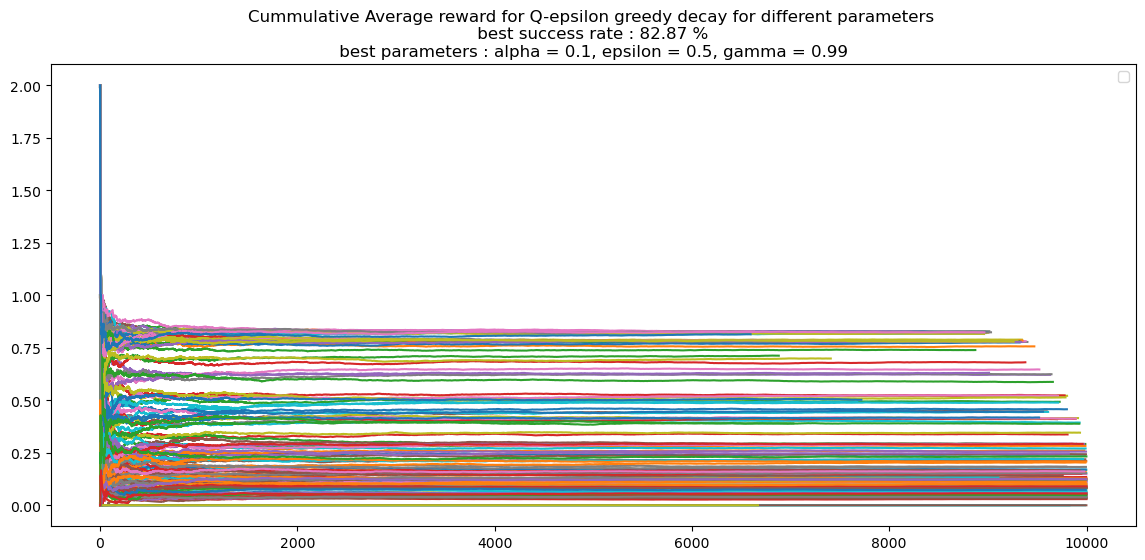

In [160]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for Q-epsilon greedy decay for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

In [147]:
q_table_greedy_decay = q_train_greedy_decay(env, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:04<00:00, 2310.43it/s]

Finished Q-learning algorithm.
Average reward is : 0.0589


In [149]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=q_table_greedy_decay, max_n_episodes=10000)


100%|██████████| 10000/10000 [00:06<00:00, 1440.51it/s]

Success rate is = 82.52643294379521 %
Average number of steps to succeed is = 38.38152476349471


In [161]:
# SARSA optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]
alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards=[]
for al in alpha :
    for ga in gamma :
        for eps in epsilon :
            sarsa_table = sarsa_train(env, al, ga, eps, episodes = 10000, steps = 100)
            reward, success_rate, avg_nb_steps = agent_play(env, sarsa_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(eps)
            rewards.append(reward)


100%|██████████| 10000/10000 [00:02<00:00, 3453.32it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.64217060472567


100%|██████████| 10000/10000 [00:03<00:00, 2797.61it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.874274274274274


100%|██████████| 10000/10000 [00:01<00:00, 6229.20it/s]


Success rate is = 11.81 %
Average number of steps to succeed is = 9.3711


100%|██████████| 10000/10000 [00:02<00:00, 4691.47it/s]


Success rate is = 9.49 %
Average number of steps to succeed is = 12.0667


100%|██████████| 10000/10000 [00:03<00:00, 2742.80it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.039943938332165


100%|██████████| 10000/10000 [00:02<00:00, 3469.04it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.928742994395517


100%|██████████| 10000/10000 [00:05<00:00, 1991.84it/s]


Success rate is = 42.29738090327903 %
Average number of steps to succeed is = 30.528871932357188


100%|██████████| 10000/10000 [00:03<00:00, 2951.93it/s]


Success rate is = 15.573114622924585 %
Average number of steps to succeed is = 15.834666933386677


100%|██████████| 10000/10000 [00:02<00:00, 3398.82it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.173629896803927


100%|██████████| 10000/10000 [00:02<00:00, 3538.12it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.913339337536275


100%|██████████| 10000/10000 [00:05<00:00, 1725.42it/s]


Success rate is = 33.45110672347501 %
Average number of steps to succeed is = 33.196300529980256


100%|██████████| 10000/10000 [00:04<00:00, 2079.73it/s]


Success rate is = 44.91956831602525 %
Average number of steps to succeed is = 28.87446548564447


100%|██████████| 10000/10000 [00:03<00:00, 3229.63it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.74138621794872


100%|██████████| 10000/10000 [00:03<00:00, 3020.98it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.22791395697849


100%|██████████| 10000/10000 [00:04<00:00, 2152.11it/s]


Success rate is = 31.681969528806377 %
Average number of steps to succeed is = 25.341136111391382


100%|██████████| 10000/10000 [00:07<00:00, 1277.43it/s]


Success rate is = 32.91906638375266 %
Average number of steps to succeed is = 27.39365464282106


100%|██████████| 10000/10000 [00:02<00:00, 3487.85it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.950025037556333


100%|██████████| 10000/10000 [00:03<00:00, 2867.22it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.068996595233326


100%|██████████| 10000/10000 [00:02<00:00, 3366.09it/s]


Success rate is = 7.033516758379189 %
Average number of steps to succeed is = 15.405902951475738


100%|██████████| 10000/10000 [00:06<00:00, 1472.53it/s]


Success rate is = 77.59229534510433 %
Average number of steps to succeed is = 37.57656500802568


100%|██████████| 10000/10000 [00:04<00:00, 2309.70it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.82049484123009


100%|██████████| 10000/10000 [00:03<00:00, 3040.93it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.067915456275667


100%|██████████| 10000/10000 [00:04<00:00, 2489.71it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.80488782051282


100%|██████████| 10000/10000 [00:10<00:00, 955.51it/s]


Success rate is = 44.95623176323468 %
Average number of steps to succeed is = 33.664130887869945


100%|██████████| 10000/10000 [00:03<00:00, 3242.08it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.831180534695104


100%|██████████| 10000/10000 [00:03<00:00, 3268.68it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.78181636126965


100%|██████████| 10000/10000 [00:03<00:00, 3037.63it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.84800240312406


100%|██████████| 10000/10000 [00:01<00:00, 8559.61it/s]


Success rate is = 2.67 %
Average number of steps to succeed is = 5.6036


100%|██████████| 10000/10000 [00:03<00:00, 2868.60it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.634388143400763


100%|██████████| 10000/10000 [00:04<00:00, 2490.98it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.90284455128205


100%|██████████| 10000/10000 [00:01<00:00, 7097.22it/s]


Success rate is = 10.75 %
Average number of steps to succeed is = 8.3914


100%|██████████| 10000/10000 [00:03<00:00, 2987.89it/s]


Success rate is = 13.536243492190629 %
Average number of steps to succeed is = 21.124048858630356


100%|██████████| 10000/10000 [00:02<00:00, 3533.56it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.83213141025641


100%|██████████| 10000/10000 [00:02<00:00, 3629.89it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.735735735735737


100%|██████████| 10000/10000 [00:06<00:00, 1607.41it/s]


Success rate is = 77.66389066837498 %
Average number of steps to succeed is = 37.437646807601965


100%|██████████| 10000/10000 [00:04<00:00, 2131.40it/s]


Success rate is = 45.02703254105886 %
Average number of steps to succeed is = 28.828011833112313


100%|██████████| 10000/10000 [00:02<00:00, 3445.70it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.104583666933546


100%|██████████| 10000/10000 [00:04<00:00, 2443.12it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.885720004002803


100%|██████████| 10000/10000 [00:03<00:00, 2537.38it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.046173878205128


100%|██████████| 10000/10000 [00:05<00:00, 1741.79it/s]


Success rate is = 51.52351738241309 %
Average number of steps to succeed is = 29.231288343558283


100%|██████████| 10000/10000 [00:02<00:00, 3511.61it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.73595111689873


100%|██████████| 10000/10000 [00:02<00:00, 3386.60it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.95873810716074


100%|██████████| 10000/10000 [00:02<00:00, 3458.54it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.79058116232465


100%|██████████| 10000/10000 [00:04<00:00, 2284.23it/s]


Success rate is = 41.60754105007095 %
Average number of steps to succeed is = 27.560510845327386


100%|██████████| 10000/10000 [00:02<00:00, 3568.11it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.672608913370055


100%|██████████| 10000/10000 [00:02<00:00, 3366.78it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.62212212212212


100%|██████████| 10000/10000 [00:06<00:00, 1575.21it/s]


Success rate is = 74.76377534770145 %
Average number of steps to succeed is = 36.96485826520862


100%|██████████| 10000/10000 [00:05<00:00, 1970.79it/s]


Success rate is = 50.015383037637164 %
Average number of steps to succeed is = 32.06758281201928


100%|██████████| 10000/10000 [00:02<00:00, 3350.99it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.036046860919196


100%|██████████| 10000/10000 [00:02<00:00, 3501.88it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.696905977771102


100%|██████████| 10000/10000 [00:02<00:00, 3360.76it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.01872246696035


100%|██████████| 10000/10000 [00:01<00:00, 9487.47it/s]


Success rate is = 3.5700000000000003 %
Average number of steps to succeed is = 6.1745


100%|██████████| 10000/10000 [00:02<00:00, 3450.34it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.953639731651148


100%|██████████| 10000/10000 [00:03<00:00, 2951.06it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.72514268549114


100%|██████████| 10000/10000 [00:04<00:00, 2462.58it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.952409578198576


100%|██████████| 10000/10000 [00:02<00:00, 3382.41it/s]


Success rate is = 15.53 %
Average number of steps to succeed is = 13.0086


100%|██████████| 10000/10000 [00:03<00:00, 2546.78it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.967357564834284


100%|██████████| 10000/10000 [00:04<00:00, 2160.23it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.96116116116116


100%|██████████| 10000/10000 [00:06<00:00, 1641.96it/s]


Success rate is = 38.922457200402825 %
Average number of steps to succeed is = 26.233434038267877


100%|██████████| 10000/10000 [00:06<00:00, 1597.24it/s]


Success rate is = 30.834426394914743 %
Average number of steps to succeed is = 26.149127232368077


100%|██████████| 10000/10000 [00:05<00:00, 1993.44it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.925610732879456


100%|██████████| 10000/10000 [00:03<00:00, 2931.82it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.904013612251028


100%|██████████| 10000/10000 [00:04<00:00, 2129.17it/s]


Success rate is = 15.832246413163439 %
Average number of steps to succeed is = 22.292966790408347


100%|██████████| 10000/10000 [00:03<00:00, 2677.69it/s]


Success rate is = 24.123773282595636 %
Average number of steps to succeed is = 20.254155818145403


100%|██████████| 10000/10000 [00:03<00:00, 2778.83it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.907361041562343


100%|██████████| 10000/10000 [00:03<00:00, 2901.01it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.90073124311329


100%|██████████| 10000/10000 [00:07<00:00, 1416.57it/s]


Success rate is = 78.39136936552019 %
Average number of steps to succeed is = 37.071993163853875


100%|██████████| 10000/10000 [00:06<00:00, 1475.58it/s]


Success rate is = 67.94365595987621 %
Average number of steps to succeed is = 36.61370184612101


100%|██████████| 10000/10000 [00:03<00:00, 3136.36it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.850580464371497


100%|██████████| 10000/10000 [00:03<00:00, 2676.60it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.918477716574863


100%|██████████| 10000/10000 [00:04<00:00, 2461.18it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.853739113024325


100%|██████████| 10000/10000 [00:06<00:00, 1641.52it/s]


Success rate is = 41.665825340737 %
Average number of steps to succeed is = 25.990610802624936


100%|██████████| 10000/10000 [00:03<00:00, 3273.34it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.8426955041554


100%|██████████| 10000/10000 [00:03<00:00, 3158.47it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.7887943971986


100%|██████████| 10000/10000 [00:02<00:00, 3356.25it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.774661992989483


100%|██████████| 10000/10000 [00:00<00:00, 10881.60it/s]


Success rate is = 4.53 %
Average number of steps to succeed is = 5.252


100%|██████████| 10000/10000 [00:02<00:00, 3376.71it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.791670837921714


100%|██████████| 10000/10000 [00:03<00:00, 2584.48it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.80650976464697


100%|██████████| 10000/10000 [00:03<00:00, 3156.90it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.857886830245366


100%|██████████| 10000/10000 [00:01<00:00, 7628.67it/s]


Success rate is = 11.04 %
Average number of steps to succeed is = 7.4012


100%|██████████| 10000/10000 [00:03<00:00, 2707.11it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.885725741780274


100%|██████████| 10000/10000 [00:03<00:00, 2929.86it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.80100150225338


100%|██████████| 10000/10000 [00:03<00:00, 3282.62it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.800060072086502


100%|██████████| 10000/10000 [00:02<00:00, 4390.79it/s]


Success rate is = 7.2214442888577715 %
Average number of steps to succeed is = 11.914382876575315


100%|██████████| 10000/10000 [00:03<00:00, 3133.03it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.078478478478477


100%|██████████| 10000/10000 [00:02<00:00, 3560.53it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.850590827158022


100%|██████████| 10000/10000 [00:06<00:00, 1503.07it/s]


Success rate is = 46.11235497659271 %
Average number of steps to succeed is = 28.87207408915123


100%|██████████| 10000/10000 [00:02<00:00, 4309.16it/s]


Success rate is = 8.450000000000001 %
Average number of steps to succeed is = 10.1776


100%|██████████| 10000/10000 [00:04<00:00, 2461.98it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.910192230676813


100%|██████████| 10000/10000 [00:03<00:00, 2519.15it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.90732586068855


100%|██████████| 10000/10000 [00:02<00:00, 3519.79it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.56194955964772


100%|██████████| 10000/10000 [00:03<00:00, 2857.42it/s]


Success rate is = 27.57791361859906 %
Average number of steps to succeed is = 22.09810602264756


100%|██████████| 10000/10000 [00:02<00:00, 3449.58it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.171022329027736


100%|██████████| 10000/10000 [00:02<00:00, 3569.44it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.05019537120529


100%|██████████| 10000/10000 [00:05<00:00, 1811.86it/s]


Success rate is = 41.95840735709061 %
Average number of steps to succeed is = 32.87459504650434


100%|██████████| 10000/10000 [00:04<00:00, 2120.41it/s]


Success rate is = 15.883306320907616 %
Average number of steps to succeed is = 27.008002431118314


100%|██████████| 10000/10000 [00:03<00:00, 3267.68it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.954741163512566


100%|██████████| 10000/10000 [00:03<00:00, 3076.57it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.913805185704273


100%|██████████| 10000/10000 [00:02<00:00, 3437.18it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.58374211632796


100%|██████████| 10000/10000 [00:01<00:00, 5139.66it/s]


Success rate is = 6.64132826565313 %
Average number of steps to succeed is = 11.80736147229446


100%|██████████| 10000/10000 [00:02<00:00, 3559.71it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.078125


100%|██████████| 10000/10000 [00:03<00:00, 3295.54it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.939102564102566


100%|██████████| 10000/10000 [00:06<00:00, 1604.57it/s]


Success rate is = 65.31427370191297 %
Average number of steps to succeed is = 35.85190245953332


100%|██████████| 10000/10000 [00:02<00:00, 3354.24it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 16.140980647748922


100%|██████████| 10000/10000 [00:03<00:00, 2520.58it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.88201121794872


100%|██████████| 10000/10000 [00:04<00:00, 2221.01it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.073388065678813


100%|██████████| 10000/10000 [00:04<00:00, 2325.02it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.774484277989185


100%|██████████| 10000/10000 [00:04<00:00, 2367.91it/s]


Success rate is = 7.205764611689351 %
Average number of steps to succeed is = 16.792433947157726


100%|██████████| 10000/10000 [00:02<00:00, 3508.46it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.960332565361114


100%|██████████| 10000/10000 [00:02<00:00, 3373.25it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.884014423076923


100%|██████████| 10000/10000 [00:03<00:00, 3282.30it/s]


Success rate is = 15.699419651791075 %
Average number of steps to succeed is = 18.411046627976788


100%|██████████| 10000/10000 [00:01<00:00, 6167.15it/s]


Success rate is = 12.16 %
Average number of steps to succeed is = 9.6632


100%|██████████| 10000/10000 [00:02<00:00, 3455.41it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.155286343612335


100%|██████████| 10000/10000 [00:03<00:00, 2777.00it/s]


Success rate is = 29.858674952390494 %
Average number of steps to succeed is = 22.83030971233838


100%|██████████| 10000/10000 [00:02<00:00, 3477.45it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.01821821821822


100%|██████████| 10000/10000 [00:06<00:00, 1481.24it/s]


Success rate is = 23.167600373482728 %
Average number of steps to succeed is = 34.53524743230626


100%|██████████| 10000/10000 [00:02<00:00, 3382.58it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.934001001502253


100%|██████████| 10000/10000 [00:03<00:00, 3242.93it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.868589743589745


100%|██████████| 10000/10000 [00:10<00:00, 949.89it/s]


Success rate is = 25.078212989613313 %
Average number of steps to succeed is = 37.116881491678136


100%|██████████| 10000/10000 [00:04<00:00, 2105.58it/s]


Success rate is = 13.059999999999999 %
Average number of steps to succeed is = 14.7204


100%|██████████| 10000/10000 [00:04<00:00, 2128.00it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.04594134721249


100%|██████████| 10000/10000 [00:03<00:00, 3027.12it/s]


Success rate is = 17.45 %
Average number of steps to succeed is = 11.779


100%|██████████| 10000/10000 [00:02<00:00, 4396.41it/s]


Success rate is = 4.93 %
Average number of steps to succeed is = 9.1351


100%|██████████| 10000/10000 [00:08<00:00, 1207.55it/s]


Success rate is = 49.36657131181038 %
Average number of steps to succeed is = 31.611360850020432


100%|██████████| 10000/10000 [00:04<00:00, 2319.68it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.80138221153846


100%|██████████| 10000/10000 [00:04<00:00, 2409.42it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.764275696253257


100%|██████████| 10000/10000 [00:04<00:00, 2275.76it/s]


Success rate is = 28.81543253290465 %
Average number of steps to succeed is = 23.59951773334673


100%|██████████| 10000/10000 [00:04<00:00, 2263.62it/s]


Success rate is = 12.876878088131491 %
Average number of steps to succeed is = 25.763335686195422


100%|██████████| 10000/10000 [00:03<00:00, 3309.42it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.784576865297947


100%|██████████| 10000/10000 [00:02<00:00, 3444.85it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.63822969860819


100%|██████████| 10000/10000 [00:02<00:00, 3538.61it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.935277026350064


100%|██████████| 10000/10000 [00:01<00:00, 6214.04it/s]


Success rate is = 4.84 %
Average number of steps to succeed is = 9.6967


100%|██████████| 10000/10000 [00:04<00:00, 2426.44it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.89440496446802


100%|██████████| 10000/10000 [00:03<00:00, 2500.30it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.865965965965966


100%|██████████| 10000/10000 [00:02<00:00, 4979.63it/s]


Success rate is = 5.02050205020502 %
Average number of steps to succeed is = 8.042604260426042


100%|██████████| 10000/10000 [00:02<00:00, 3559.00it/s]


Success rate is = 8.601720344068815 %
Average number of steps to succeed is = 11.942288457691538


100%|██████████| 10000/10000 [00:03<00:00, 2559.36it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.829944917376064


100%|██████████| 10000/10000 [00:03<00:00, 2526.19it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.015720436567538


100%|██████████| 10000/10000 [00:06<00:00, 1535.18it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.95444533440128


100%|██████████| 10000/10000 [00:02<00:00, 3939.45it/s]


Success rate is = 4.6899999999999995 %
Average number of steps to succeed is = 8.1937


100%|██████████| 10000/10000 [00:04<00:00, 2246.47it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.672674476819864


100%|██████████| 10000/10000 [00:04<00:00, 2377.92it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.593834451005904


100%|██████████| 10000/10000 [00:03<00:00, 2574.24it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.798858630356428


100%|██████████| 10000/10000 [00:02<00:00, 3640.58it/s]


Success rate is = 8.4 %
Average number of steps to succeed is = 10.3924


100%|██████████| 10000/10000 [00:06<00:00, 1623.30it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.979465090654113


100%|██████████| 10000/10000 [00:05<00:00, 1801.59it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.694018635407275


100%|██████████| 10000/10000 [00:05<00:00, 1703.80it/s]


Success rate is = 9.983831851253031 %
Average number of steps to succeed is = 25.920270816491513


100%|██████████| 10000/10000 [00:01<00:00, 5893.51it/s]


Success rate is = 4.6 %
Average number of steps to succeed is = 6.2181


100%|██████████| 10000/10000 [00:04<00:00, 2417.35it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.86328125


100%|██████████| 10000/10000 [00:04<00:00, 2446.48it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.81535228182546


100%|██████████| 10000/10000 [00:02<00:00, 3384.39it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.543624161073826


100%|██████████| 10000/10000 [00:07<00:00, 1370.10it/s]


Success rate is = 7.6190476190476195 %
Average number of steps to succeed is = 35.79047619047619


100%|██████████| 10000/10000 [00:03<00:00, 2820.85it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.85745767805269


100%|██████████| 10000/10000 [00:03<00:00, 2940.52it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.681850035038543


100%|██████████| 10000/10000 [00:03<00:00, 3294.06it/s]


Success rate is = 10.89 %
Average number of steps to succeed is = 16.031


100%|██████████| 10000/10000 [00:01<00:00, 5227.14it/s]


Success rate is = 4.26 %
Average number of steps to succeed is = 8.7687


100%|██████████| 10000/10000 [00:03<00:00, 2924.33it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.026948507313165


100%|██████████| 10000/10000 [00:02<00:00, 3453.95it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.529494241362045


100%|██████████| 10000/10000 [00:05<00:00, 1681.17it/s]


Success rate is = 14.583751253761285 %
Average number of steps to succeed is = 21.2592778335005


100%|██████████| 10000/10000 [00:04<00:00, 2188.90it/s]


Success rate is = 15.967983991995998 %
Average number of steps to succeed is = 15.585892946473237


100%|██████████| 10000/10000 [00:04<00:00, 2327.80it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.934001001502253


100%|██████████| 10000/10000 [00:06<00:00, 1549.66it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 18.00510766149224


100%|██████████| 10000/10000 [00:05<00:00, 1984.97it/s]


Success rate is = 17.408704352176088 %
Average number of steps to succeed is = 18.733466733366683


100%|██████████| 10000/10000 [00:01<00:00, 5834.10it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 6.087


100%|██████████| 10000/10000 [00:03<00:00, 2508.80it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.86482427155302


100%|██████████| 10000/10000 [00:04<00:00, 2157.17it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.8192288432649


100%|██████████| 10000/10000 [00:05<00:00, 1786.54it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 17.76231971153846


100%|██████████| 10000/10000 [00:06<00:00, 1506.66it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 27.93751908008548


In [ ]:
df = pd.DataFrame()

df["epsilon"]=epsilons
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
/tmp/ipykernel_57852/3197099448.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.a

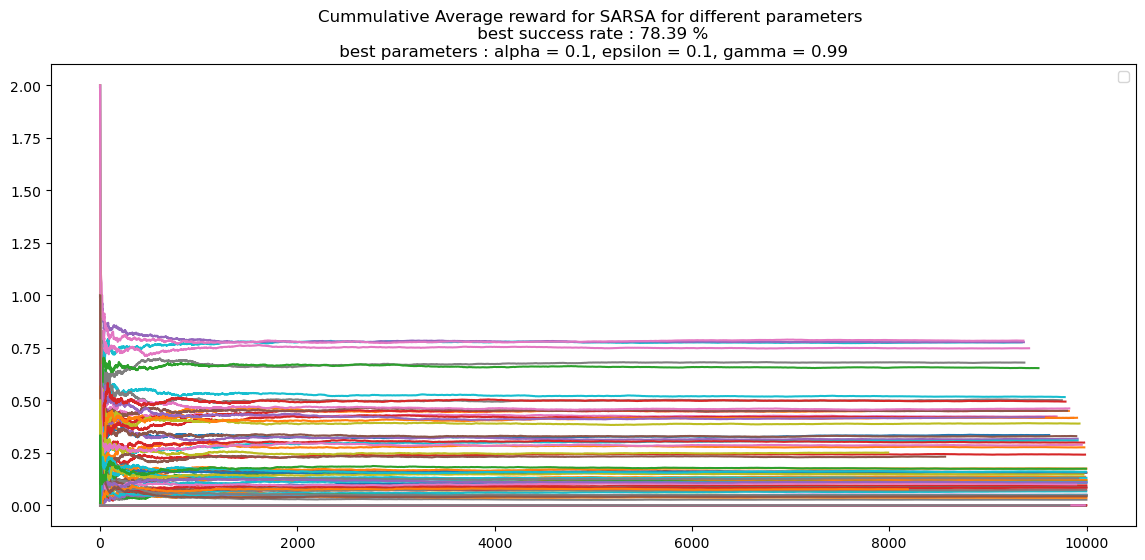

In [172]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for SARSA for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

In [168]:
sarsa_table = sarsa_train(env, alpha = 0.1, gamma = 0.99, epsilon = 0.1, episodes = 10000, steps = 100)

100%|██████████| 10000/10000 [00:04<00:00, 2094.41it/s]


In [169]:
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table, max_n_episodes=10000)


100%|██████████| 10000/10000 [00:06<00:00, 1591.16it/s]

Success rate is = 77.58326216908625 %
Average number of steps to succeed is = 37.04707514944492


In all the past section, we've trained our algorithms in the slippery envirement with`is_slippery=False`. We will now establish a new frozen lake environment with `is_slippery=False`

In [210]:
env_no_slip = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

Re-training for the new environment

In [211]:
q_table = q_train(env_no_slip)
q_table_greedy = q_train_greedy(env_no_slip)
q_table_greedy_decay=q_train_greedy_decay(env_no_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)
sarsa_table = sarsa_train(env_no_slip)


Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:35<00:00, 278.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 431.20it/s]


Finished Q-learning algorithm.
Average reward is : 0.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:03<00:00, 3186.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.3448


100%|██████████| 10000/10000 [00:17<00:00, 580.26it/s]


Re-calculating the performance 

In [219]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_no_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_no_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_no_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_no_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_no_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:01<00:00, 9466.49it/s]


Success rate is = 100.0 %
Average number of steps to succeed is = 6.0


100%|██████████| 10000/10000 [00:15<00:00, 658.85it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


100%|██████████| 10000/10000 [00:22<00:00, 435.03it/s]


Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


100%|██████████| 10000/10000 [00:01<00:00, 6437.19it/s]


Success rate is = 100.0 %
Average number of steps to succeed is = 6.0


100%|██████████| 10000/10000 [00:23<00:00, 431.47it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 100.0


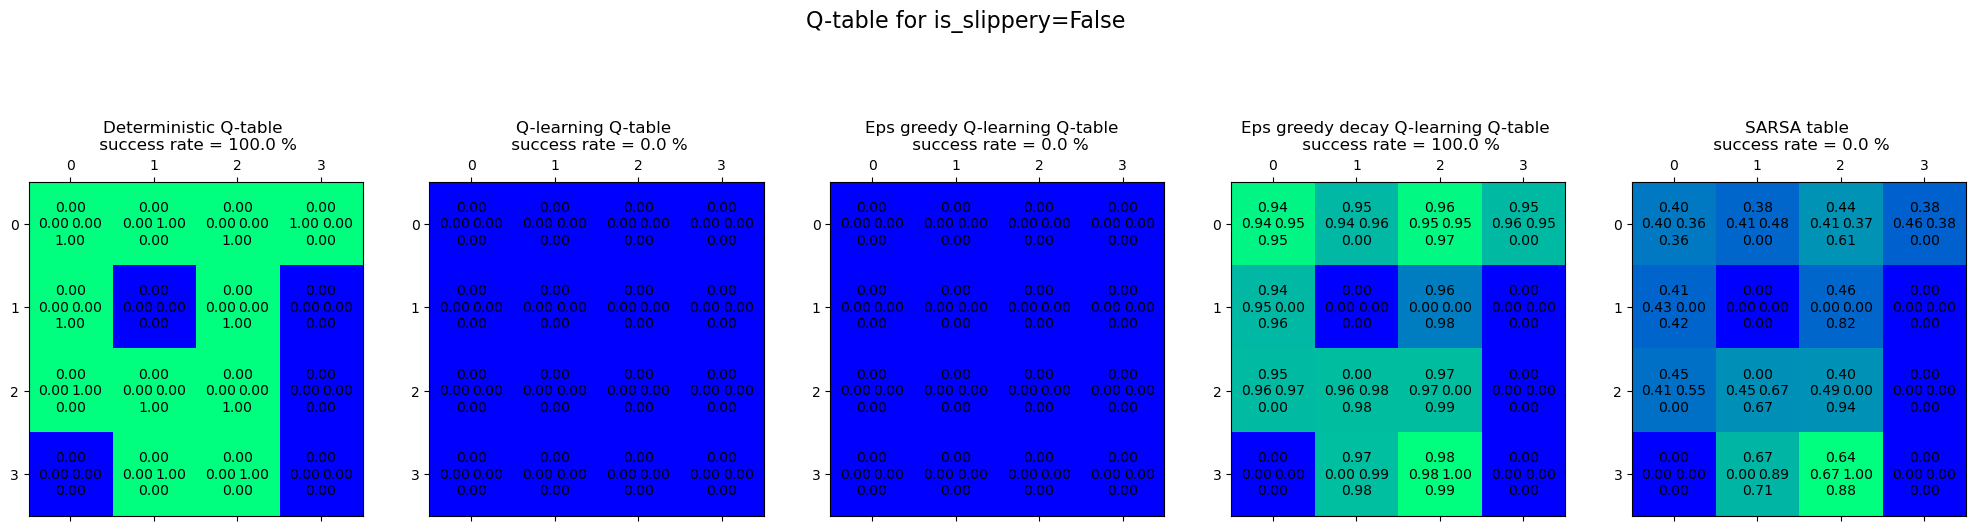

In [222]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.suptitle("Q-table for is_slippery=False", fontsize=16)

fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {100*round(success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {100*round(success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {100*round(success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {100*round(success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {100*round(success_rate_sarsa,2)} %")
plt.show()

/tmp/ipykernel_57852/3416567757.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_57852/3416567757.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_57852/3416567757.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_57852/3416567757.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate 

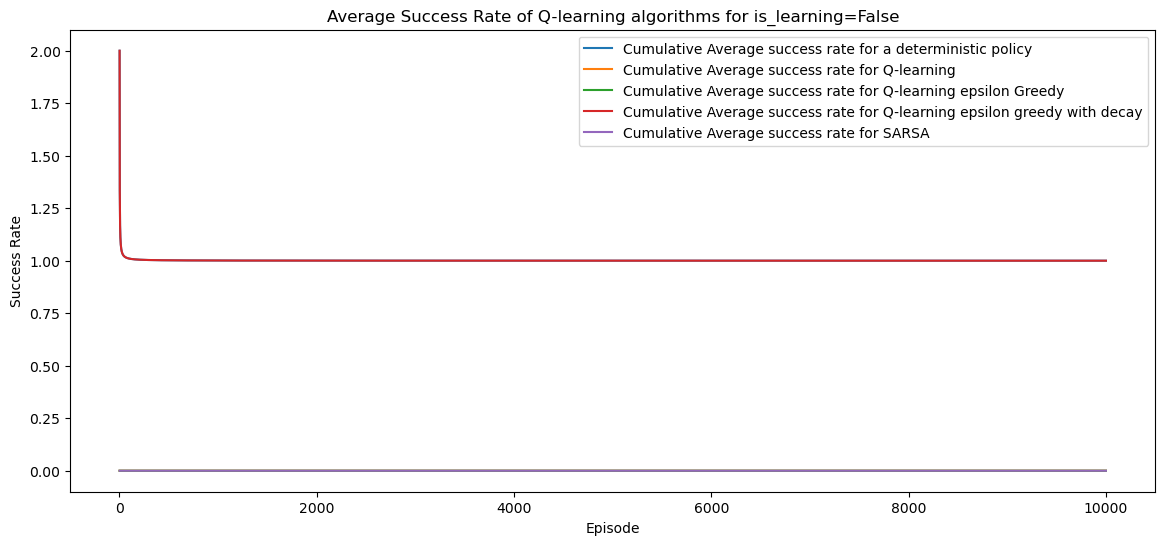

In [223]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=False')
plt.legend()
plt.show()

## 3. Conclusion :
We've established 3 variations of the Q-learning algorithm. As well as the SARSA algorithm, we've benchmarked their performance for both `slippery` and `non-slippery` environments. Furthermore, we've optimized their performance through a manual grid search of the hyperparameters.